In [53]:
Ns=16 #only even numbers
N, PBC = 4, False
J, U,V = 1,20,-0
Nf, vNf = 70, 70
#vNf = Nf

In [54]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average,sort, var, conj, math, var,append, save,argsort, delete
from numpy.linalg import inv
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

def genBase(js_,N_,base_,baseQ1_):
    if N_==0:
        base_.append( [0]*Ns )
        for j in js_:
            base_[-1][j]+=1
        baseQ1_.append(list([x for x in js_]))
    else:
        leftBound = 0
        if len(js_)>0:
            leftBound = js_[-1]
        for j in range(leftBound,Ns):
            genBase(js_+[j],N_-1,base_,baseQ1_)
        
base, baseQ1 = [], []
base1, base1Q1 = [],[]
base2, base2Q1= [],[]

genBase([],1,base1,base1Q1)
genBase([],2,base2,base2Q1)
genBase([],N,base,baseQ1)

NoS1, NoS2, NoS = len(base1), len(base2), len(base)

print('Number of base states =',NoS)

Number of base states = 364


In [55]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################
def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]

        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef

        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU

        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = sign(v[0,0])*v[:,0]

H = generateHamitlonian(base, J,U,V)
E, v = eigsh(H,k=1,which='SA')  
E_R = E[0]
GS = sign(v[0,0])*v[:,0]
print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference GS... DONE in  26.485681533813477 [ms]


In [56]:
def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

print("Only functions")

Only functions


In [57]:
#########################333####################################################################
combs, combsh = [], []

for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        if n+n2 < Ns:
            combsh.append([n,n2])
baseMask = (-abs(GS)).argsort()[:max(Nf,vNf)]

frac = 0.0
for m in baseMask:
   # print(GS[m])
    frac+= abs(GS[m])**2
print("Frac=",frac)

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out

A1 = zeros([Nf,int((Ns+1)/2)],dtype=int)
A2h = zeros([Nf,len(combsh)],dtype=int)
vA2h = zeros([vNf,len(combsh)],dtype=int)
B = zeros(Nf,dtype=float)
vB = zeros(vNf,dtype=float)

for i in range(Nf):
    A1[i] = array(base[baseMask[i]][0:int((Ns+1)/2)])  + array(base[baseMask[i]][Ns:int((Ns-1)/2):-1])
    A2h[i] = Ph(base[baseMask[i]])
    B[i] = GS[baseMask[i]]
    
for i in range(vNf):
    vA2h[i] = Ph(base[baseMask[i]])
    vB[i] = GS[baseMask[i]]

Frac= 0.79302795894036


In [58]:
combshmask = []
toRem = []

for j in range(len(A2h[0,:])):
    if sum(A2h[:,j])==0:
        combshmask.append(0)
        toRem.append(j)
    else:
        combshmask.append(1)

A2heff = delete(A2h, toRem, 1)

def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )

Norms1f = zeros(Nf,dtype=float)
for i in range(Nf):
    Norms1f[i]= norm(base[baseMask[i]])
    
vNorms1f = zeros(vNf,dtype=float)
for i in range(vNf):
    vNorms1f[i]= norm(base[baseMask[i]])

def variance1h( psi ):
    c = real(array(Norms1f)*exp(A1.dot(log(psi,dtype=complex))))
    return sum((c-B)**2)

def findPsi1(method='half'):
    print("Looking for Psi_A1...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    if method=='half':
        psi0h = GS_1atom[0:int((Ns+1)/2)]
        reth = basinhopping(variance1h, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
        psi = append(reth.x, reth.x[::-1])
    if method=='whole':
        psi0 = GS_1atom
        ret = basinhopping(variance1, psi0, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=5)
        psi = ret.x
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

In [59]:
####################################################
## Functions for Ansatz 2 ##########################
####################################################
def variance2h( psi ):
    c = Norms1f*exp(A2h.dot(log(psi,dtype=float)))
    return sum((c-B)**2)

def variance2hv( psi ):
    c = vNorms1f*exp(vA2h.dot(log(psi,dtype=float)))
    return sum((c-vB)**2)

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out

print("Only functions")

Only functions


In [60]:
import numpy as np
AT = transpose(A2heff)
Beff = log(B/Norms1f)
phiA21Deff = exp(inv(AT.dot(A2heff)).dot(AT).dot(Beff))
phiA21D = []
iterr = 0
for mask in combshmask:
    if mask ==0:
        phiA21D.append(0)
    else:
        phiA21D.append(phiA21Deff[iterr])
        iterr+=1
phiA21D = psi14to12(array(phiA21D))
# print(array(phiA21D).dot(GS_2atom)/array(phiA21D).dot((phiA21D)))
# #print(GS_2atom)

6.396983674840773e-11


In [1310]:
####################################################
## Compute best Ansatz functions ###################
####################################################
psiA1 = findPsi1()

phiA2 = reshapePhiTo2D(phiA21D)
phiJ = reshapePhiTo2D(GS_2atom)

Looking for Psi_A1... DONE in 134.82975959777832 [ms]


(E_GS-E_free)/(|N E_free|) =  -2.2212663316437564
|<ED|A1>|^2 =  0.3867690638302377
|<ED|A2>|^2 =  5.542756418217907e+49
v|<ED|A2>|^2 =  1.0015836915872937e+157
|<ED|J>|^2 =  0.25036162818760443
v|<ED|J>|^2 =  0.2502143226163608


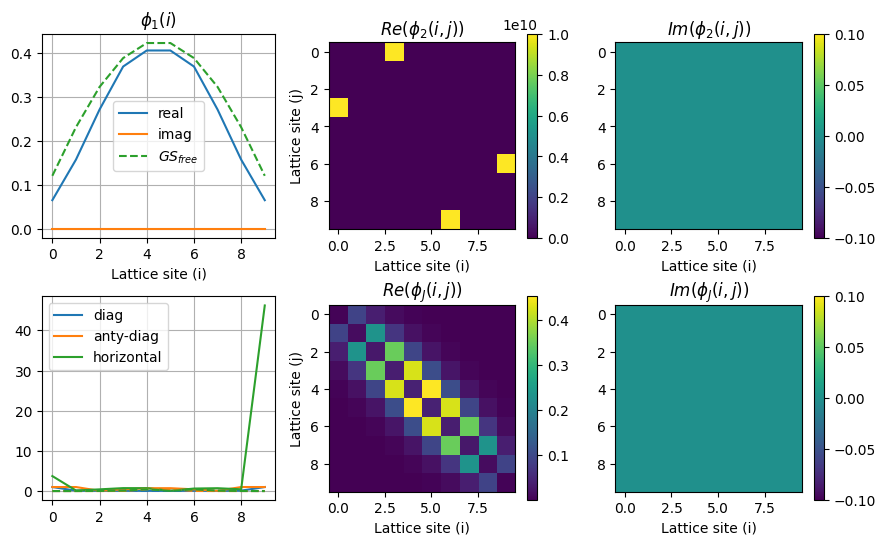

In [1311]:
####################################################
## Plot Ansatz functions ###########################
####################################################

import numpy as np

print('(E_GS-E_free)/(|N E_free|) = ', (E_R-N*E_1atom)/(abs(N*E_1atom)) )

print('|<ED|A1>|^2 = ',(1-0.5*variance1h(psiA1[0:int(Ns/2)]))**2)
print('|<ED|A2>|^2 = ',(1-0.5*variance2h(psi12to14(phiA21D)))**2)
print('v|<ED|A2>|^2 = ',(1-0.5*variance2hv(psi12to14(phiA21D)))**2)
print('|<ED|J>|^2 = ',(1-0.5*variance2h(psi12to14(GS_2atom)))**2)
print('v|<ED|J>|^2 = ',(1-0.5*variance2hv(psi12to14(GS_2atom)))**2)

fig, ax = plt.subplots(2,3,figsize=(9,5.5))
ax[0,0].plot(real(psiA1),label='real')
ax[0,0].plot(imag(psiA1),label='imag')
ax[0,0].plot(GS_1atom,'--',label = '$GS_{free}$')
cmap = ax[0,1].imshow(real(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[0,2].imshow(imag(phiA2))
cbar = plt.colorbar(cmap)
cmap = ax[1,1].imshow(real(phiJ))
cbar = plt.colorbar(cmap)
cmap = ax[1,2].imshow(imag(phiJ))
cbar = plt.colorbar(cmap)

ax[1,0].plot([real(phiA2)[i,i] for i in range(Ns)],label='diag')
ax[1,0].plot([real(phiA2)[i,Ns-1-i] for i in range(Ns)],label='anty-diag')
ax[1,0].plot([real(phiA2)[int(Ns/2),i] for i in range(Ns)],label='horizontal')

ax[1,0].plot([real(phiJ)[i,i] for i in range(Ns)],'--',c='tab:blue')
ax[1,0].plot([real(phiJ)[i,Ns-1-i] for i in range(Ns)],'--',c='tab:orange')
ax[1,0].plot([real(phiJ)[int(Ns/2),i] for i in range(Ns)],'--',c='tab:green')


ax[0,0].grid()
ax[1,0].grid()
ax[1,0].legend()
ax[0,0].legend()
ax[0,0].set_xlabel('Lattice site (i)')
ax[0,1].set_xlabel('Lattice site (i)')
ax[0,1].set_ylabel('Lattice site (j)')
ax[0,2].set_xlabel('Lattice site (i)')
#ax[0,2].set_ylabel('Lattice site (j)')

ax[0,0].set_title('$\phi_1(i)$')
ax[0,1].set_title('$Re(\phi_2(i,j))$')
ax[0,2].set_title('$Im(\phi_2(i,j))$')

ax[1,1].set_xlabel('Lattice site (i)')
ax[1,1].set_ylabel('Lattice site (j)')
ax[1,2].set_xlabel('Lattice site (i)')
#ax[1,2].set_ylabel('Lattice site (j)')

ax[1,1].set_title('$Re(\phi_J(i,j))$')
ax[1,2].set_title('$Im(\phi_J(i,j))$')
plt.tight_layout()
#plt.savefig("40_-1.97_N3_Ns30.func.png")
np.save(("Ns%i_N%i_J%f_U%f_V%f"%(Ns,N,J,U,V)),real(phiA2))
plt.savefig(("2_Ns%i_N%i_J%f_U%f_V%f.png"%(Ns,N,J,U,V)))
#print(real(phiA2))
plt.show()